<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [ ]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

In [11]:
!gdown 1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO

Downloading...
From (original): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
From (redirected): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO&confirm=t&uuid=e7caceb7-2233-4b55-b93e-172c80e8427d
To: /content/handout.tar.gz
100% 884M/884M [00:26<00:00, 33.5MB/s]


In [14]:
!tar -xvf handout.tar.gz

data/
data/captions_tokenized.json
data/image_codes.npy


In [15]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 151 ms, sys: 360 ms, total: 512 ms
Wall time: 512 ms



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [16]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [17]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [18]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]:
            word_counts[word] += 1

In [19]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [20]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [21]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [133]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [134]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid.unsqueeze(0), initial_cell.unsqueeze(0)))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [135]:
network = CaptionNet(n_tokens)

In [136]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [137]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)

    loss = F.cross_entropy(
        logits_for_next.view(-1, logits_for_next.shape[-1]),
        captions_ix_next.view(-1),
        ignore_index=pad_ix
    )

    return loss

In [138]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

In [139]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [140]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(img_codes))
train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=42)

train_img_codes = img_codes[train_idx]
val_img_codes = img_codes[val_idx]
train_captions = [captions[i] for i in train_idx]
val_captions = [captions[i] for i in val_idx]

In [141]:
from random import choice

def generate_batch(img_codes, captions_list, batch_size, max_caption_len=None):
    # sample random numbers for image/caption indices
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #get corresponding captions
    captions_for_batch_images = [captions_list[i] for i in random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = [choice(caps) for caps in captions_for_batch_images]

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [142]:
generate_batch(train_img_codes, train_captions, 3)

(tensor([[0.3865, 0.4977, 0.8962,  ..., 0.5755, 0.1305, 0.7871],
         [0.8103, 0.1116, 0.1586,  ..., 1.0131, 1.3548, 0.2425],
         [0.5896, 0.1727, 0.3704,  ..., 0.3604, 0.2321, 0.3001]]),
 tensor([[   1,   24,    0,   14,    0, 2709,   58,  668,   15, 3274,   12,    2],
         [   1,  112, 1574,  355,   15, 3001, 3485,   15, 1300,    2,    3,    3],
         [   1,   24,  500, 1359,   58,    4, 2721,   24,  500,    2,    3,    3]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [146]:
batch_size = 64
n_epochs = 100
n_batches_per_epoch = 15
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [144]:
len(train_img_codes)

106458

In [147]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))


        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 15/15 [00:07<00:00,  1.99it/s]



Epoch: 0, train loss: 7.898370424906413, val loss: 6.0324455261230465


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]



Epoch: 1, train loss: 5.387456035614013, val loss: 5.066907691955566


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]



Epoch: 2, train loss: 5.008865642547607, val loss: 4.991776371002198


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]



Epoch: 3, train loss: 4.867314624786377, val loss: 4.786474990844726


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]



Epoch: 4, train loss: 4.713889217376709, val loss: 4.679052543640137


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]



Epoch: 5, train loss: 4.641456985473633, val loss: 4.534134292602539


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]



Epoch: 6, train loss: 4.580514017740885, val loss: 4.4851908683776855


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]



Epoch: 7, train loss: 4.454292106628418, val loss: 4.413049602508545


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]



Epoch: 8, train loss: 4.385394509633382, val loss: 4.3795167922973635


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]



Epoch: 9, train loss: 4.355948193868001, val loss: 4.2659751892089846


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]



Epoch: 10, train loss: 4.2592129866282145, val loss: 4.117119026184082


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]



Epoch: 11, train loss: 4.312207380930583, val loss: 4.26090259552002


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]



Epoch: 12, train loss: 4.2295026779174805, val loss: 4.20306167602539


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]



Epoch: 13, train loss: 4.1102566878000895, val loss: 4.2024304389953615


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]



Epoch: 14, train loss: 4.141749874750773, val loss: 4.012053823471069


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]



Epoch: 15, train loss: 4.061830647786459, val loss: 4.061291933059692


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]



Epoch: 16, train loss: 4.018866984049479, val loss: 4.100172138214111


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]



Epoch: 17, train loss: 4.001491832733154, val loss: 3.962379264831543


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]



Epoch: 18, train loss: 3.9749959627787272, val loss: 3.979765605926514


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]



Epoch: 19, train loss: 3.959853919347127, val loss: 3.9033289909362794


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]



Epoch: 20, train loss: 3.8937699158986407, val loss: 3.922170639038086


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]



Epoch: 21, train loss: 3.931954924265544, val loss: 3.8400484561920165


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]



Epoch: 22, train loss: 3.879781166712443, val loss: 3.8341070652008056


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]



Epoch: 23, train loss: 3.829155937830607, val loss: 3.849843454360962


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]



Epoch: 24, train loss: 3.8067198594411216, val loss: 3.743896007537842


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]



Epoch: 25, train loss: 3.7759519100189207, val loss: 3.7180206298828127


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]



Epoch: 26, train loss: 3.7352321624755858, val loss: 3.7570515155792235


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]



Epoch: 27, train loss: 3.7504844665527344, val loss: 3.7312084197998048


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]



Epoch: 28, train loss: 3.6498871485392255, val loss: 3.535950803756714


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]



Epoch: 29, train loss: 3.703804047902425, val loss: 3.6917574405670166


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch: 30, train loss: 3.676054318745931, val loss: 3.6220042228698732


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]



Epoch: 31, train loss: 3.678474203745524, val loss: 3.5913798809051514


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]



Epoch: 32, train loss: 3.577096176147461, val loss: 3.588607740402222


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]



Epoch: 33, train loss: 3.6234183311462402, val loss: 3.5525757312774657


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]



Epoch: 34, train loss: 3.5999244372049968, val loss: 3.4819758415222166


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch: 35, train loss: 3.5806708176930746, val loss: 3.517309617996216


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]



Epoch: 36, train loss: 3.509567721684774, val loss: 3.554540586471558


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]



Epoch: 37, train loss: 3.541935094197591, val loss: 3.415068006515503


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]



Epoch: 38, train loss: 3.4775567213694254, val loss: 3.5840389251708986


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]



Epoch: 39, train loss: 3.500460720062256, val loss: 3.480553722381592


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]



Epoch: 40, train loss: 3.480550273259481, val loss: 3.4610787868499755


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]



Epoch: 41, train loss: 3.395999383926392, val loss: 3.5065481185913088


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]



Epoch: 42, train loss: 3.4533372720082602, val loss: 3.3503663539886475


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]



Epoch: 43, train loss: 3.4164189179738362, val loss: 3.4683528900146485


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]



Epoch: 44, train loss: 3.4498747189839682, val loss: 3.46154522895813


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]



Epoch: 45, train loss: 3.353750292460124, val loss: 3.2633355140686033


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]



Epoch: 46, train loss: 3.344705661137899, val loss: 3.3325139045715333


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]



Epoch: 47, train loss: 3.3656795978546143, val loss: 3.3540092945098876


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]



Epoch: 48, train loss: 3.3564897696177165, val loss: 3.2261507511138916


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]



Epoch: 49, train loss: 3.293395455678304, val loss: 3.3902486324310304


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]



Epoch: 50, train loss: 3.2936544895172117, val loss: 3.2737608909606934


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]



Epoch: 51, train loss: 3.2971185366312663, val loss: 3.354568433761597


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]



Epoch: 52, train loss: 3.3221335728963215, val loss: 3.23461709022522


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]



Epoch: 53, train loss: 3.2448055108388263, val loss: 3.3663383960723876


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]



Epoch: 54, train loss: 3.273744471867879, val loss: 3.261867904663086


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]



Epoch: 55, train loss: 3.2792611757914227, val loss: 3.28342604637146


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]



Epoch: 56, train loss: 3.269238758087158, val loss: 3.2917927742004394


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]



Epoch: 57, train loss: 3.2287135759989423, val loss: 3.2061519622802734


100%|██████████| 15/15 [00:07<00:00,  2.10it/s]



Epoch: 58, train loss: 3.2120361646016438, val loss: 3.3179916858673097


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]



Epoch: 59, train loss: 3.2724801381429036, val loss: 3.1775434970855714


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]



Epoch: 60, train loss: 3.22693616549174, val loss: 3.1415608882904054


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]



Epoch: 61, train loss: 3.187952248255412, val loss: 3.1899974822998045


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]



Epoch: 62, train loss: 3.2495694319407145, val loss: 3.144290256500244


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]



Epoch: 63, train loss: 3.1894921620686847, val loss: 3.2132190227508546


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]



Epoch: 64, train loss: 3.185934336980184, val loss: 3.158629894256592


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]



Epoch: 65, train loss: 3.1854472955067954, val loss: 3.214940404891968


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]



Epoch: 66, train loss: 3.1380351702372233, val loss: 3.174235153198242


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]



Epoch: 67, train loss: 3.101359558105469, val loss: 3.025335931777954


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]



Epoch: 68, train loss: 3.1459785143534345, val loss: 3.2897768020629883


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]



Epoch: 69, train loss: 3.1385300159454346, val loss: 3.1755247592926024


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]



Epoch: 70, train loss: 3.1354822158813476, val loss: 3.0988275527954103


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]



Epoch: 71, train loss: 3.1661327203114826, val loss: 3.1875452518463137


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]



Epoch: 72, train loss: 3.1537399450937906, val loss: 3.2057321071624756


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]



Epoch: 73, train loss: 3.1080135981241863, val loss: 3.0304691791534424


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]



Epoch: 74, train loss: 3.0923309485117594, val loss: 3.1701544284820558


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]



Epoch: 75, train loss: 3.1044110457102456, val loss: 3.165936803817749


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]



Epoch: 76, train loss: 3.1491415023803713, val loss: 3.1102087020874025


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]



Epoch: 77, train loss: 3.0950771967569985, val loss: 3.0743525505065916


100%|██████████| 15/15 [00:08<00:00,  1.67it/s]



Epoch: 78, train loss: 3.0460397243499755, val loss: 3.027143144607544


100%|██████████| 15/15 [00:05<00:00,  2.67it/s]



Epoch: 79, train loss: 3.0473258177439373, val loss: 3.098759126663208


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]



Epoch: 80, train loss: 3.061185185114543, val loss: 3.021349620819092


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]



Epoch: 81, train loss: 3.063252353668213, val loss: 3.064431381225586


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]



Epoch: 82, train loss: 3.0077625274658204, val loss: 3.057834434509277


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]



Epoch: 83, train loss: 2.9914613405863446, val loss: 3.1108036994934083


100%|██████████| 15/15 [00:06<00:00,  2.15it/s]



Epoch: 84, train loss: 3.0011176904042562, val loss: 3.108521747589111


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]



Epoch: 85, train loss: 3.010905949274699, val loss: 3.0808537006378174


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]



Epoch: 86, train loss: 3.0360910256703693, val loss: 3.0385454177856444


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]



Epoch: 87, train loss: 3.0532393296559652, val loss: 3.0611339569091798


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]



Epoch: 88, train loss: 3.0746184666951497, val loss: 3.050951051712036


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]



Epoch: 89, train loss: 2.9753446261088055, val loss: 3.0267961978912354


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]



Epoch: 90, train loss: 2.991144831975301, val loss: 3.0164053440093994


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]



Epoch: 91, train loss: 2.9722914854685465, val loss: 2.983262062072754


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]



Epoch: 92, train loss: 2.965161752700806, val loss: 3.0921637058258056


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]



Epoch: 93, train loss: 3.062650378545125, val loss: 3.1171470165252684


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]



Epoch: 94, train loss: 2.971356153488159, val loss: 2.970943546295166


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]



Epoch: 95, train loss: 2.956889359156291, val loss: 3.125538158416748


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]



Epoch: 96, train loss: 2.9781657059987388, val loss: 2.9536929607391356


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]



Epoch: 97, train loss: 2.961676009496053, val loss: 2.9665048599243162


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]



Epoch: 98, train loss: 2.977578322092692, val loss: 2.937632131576538


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]



Epoch: 99, train loss: 2.9413604895273844, val loss: 2.964648389816284
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [149]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [150]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [151]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.


# img = plt.imread('data/img.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.

--2025-10-28 15:13:58--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-28 15:13:59--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K   282KB/s    in 0.2s    

2025-10-28 15:14:00 (282 KB/s) - ‘data/img.jpg’ saved [54731/5473

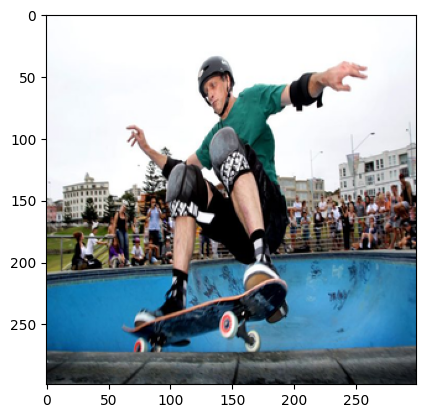

In [152]:
plt.imshow(img)

In [153]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is doing a trick on a skateboard .
a man is surfing on a skateboard on a skateboard .
a man is holding a skateboard on a skateboard .
a man is holding a skateboard on a skateboard .
a man is playing with a frisbee in the air .
a man is holding a skateboard on a skateboard .
a man is surfing on a skateboard on a skateboard .
a man is playing with a skateboard on a skateboard .
a man is holding a skateboard in the air .
a man is jumping on a skateboard on a skateboard .


### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

Попробуем простые изображения:

--2025-10-28 15:14:10--  https://img.freepik.com/premium-photo/red-apple-table-front-forest_836919-2314.jpg
Resolving img.freepik.com (img.freepik.com)... 23.46.230.145, 23.46.230.130, 2600:1413:b000:24::172e:e691, ...
Connecting to img.freepik.com (img.freepik.com)|23.46.230.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40463 (40K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  39.51K  --.-KB/s    in 0s      

2025-10-28 15:14:10 (326 MB/s) - ‘data/img.jpg’ saved [40463/40463]

a bunch of bananas in a vase with a tree .
a bunch of bananas sitting on a table .
a close up of a bunch of bananas and a tree .
a small vase with a green and white flowers .
a bunch of bananas and a table with a bunch of bananas .
a bunch of bananas and a banana with a banana .
a bunch of bananas in a vase filled with a tree .
a close up of a green vase with a fork .
a bunch of bananas sitting on a table with a tree .
a vase of flowers on

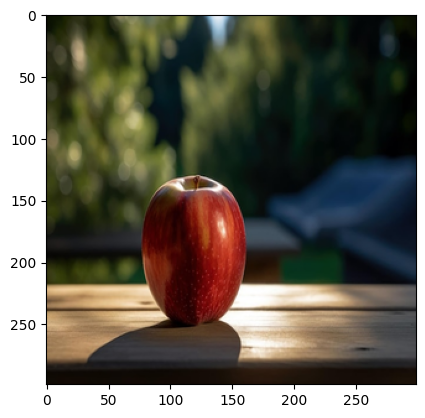

In [154]:
!wget 'https://img.freepik.com/premium-photo/red-apple-table-front-forest_836919-2314.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:14:19--  https://i.pinimg.com/originals/8c/80/20/8c8020f7fe8ccaeaa2e9abd3834bf5e2.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.0.84, 151.101.64.84, 151.101.128.84, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.0.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63682 (62K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  62.19K  --.-KB/s    in 0.001s  

2025-10-28 15:14:19 (49.4 MB/s) - ‘data/img.jpg’ saved [63682/63682]

a man riding a surfboard on a surfboard in the ocean .
a man is surfing in the ocean on a surfboard .
a man riding a surfboard on a wave in the ocean .
a man riding a surfboard on a surfboard in the ocean .
a man riding a surfboard on a wave .
a man riding a surfboard on a surfboard in the ocean .
a man riding a surfboard on a surfboard in the ocean .
a man riding a wave on a surfboard in the ocean .
a man with a surfboard on a surfboard in the ocean .
a man is surfing on

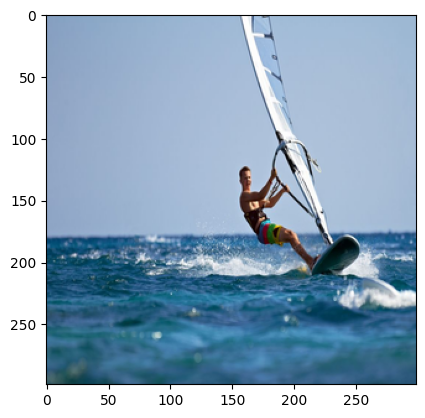

In [155]:
!wget 'https://i.pinimg.com/originals/8c/80/20/8c8020f7fe8ccaeaa2e9abd3834bf5e2.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:14:24--  https://i.pinimg.com/originals/7a/b4/72/7ab472450e8baf2e3eaca8a43d793d44.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.0.84, 151.101.64.84, 151.101.128.84, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.0.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951212 (929K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 928.92K  --.-KB/s    in 0.005s  

2025-10-28 15:14:24 (174 MB/s) - ‘data/img.jpg’ saved [951212/951212]

a group of people playing frisbee in a field .
a group of people standing on a field with a frisbee .
a group of people playing soccer on a field .
a man standing on a field with a frisbee in the background .
a group of people playing frisbee in a field .
a man is playing a game of frisbee .
a man is playing frisbee in the field .
a group of men playing frisbee in a field .
a group of people playing soccer on a field .
a group of men playing frisbee in a field .


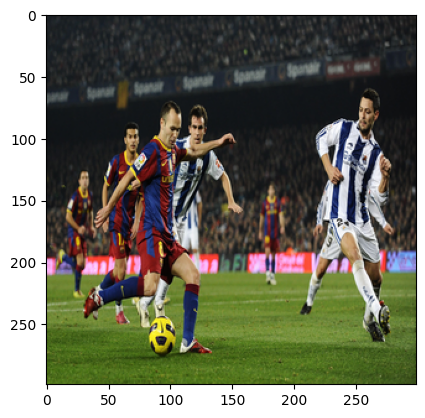

In [156]:
!wget 'https://i.pinimg.com/originals/7a/b4/72/7ab472450e8baf2e3eaca8a43d793d44.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:14:38--  https://wallpapers.com/images/hd/frisbee-1400-x-1034-background-ocqwvdkkaad0lypn.jpg
Resolving wallpapers.com (wallpapers.com)... 138.199.24.219, 2400:52e0:1500::868:1
Connecting to wallpapers.com (wallpapers.com)|138.199.24.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102915 (101K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 100.50K  --.-KB/s    in 0.005s  

2025-10-28 15:14:38 (21.3 MB/s) - ‘data/img.jpg’ saved [102915/102915]

a man standing on a beach with a frisbee .
a man is playing a game of frisbee .
a man is standing on a tennis court holding a frisbee .
a man is playing a game of frisbee .
a man standing on a field with a frisbee .
a man is playing a game of frisbee .
a man in a field playing with a frisbee .
a man is standing on a tennis court holding a frisbee .
a man riding a skateboard in the air .
a man is playing a frisbee in a field .


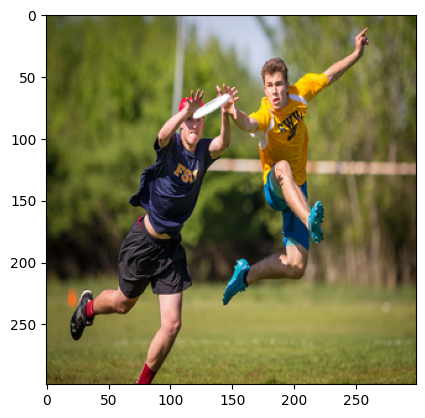

In [157]:
!wget 'https://wallpapers.com/images/hd/frisbee-1400-x-1034-background-ocqwvdkkaad0lypn.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:14:46--  https://i.pinimg.com/originals/86/af/b0/86afb044d3cef03374d78c3a988f4459.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.0.84, 151.101.64.84, 151.101.128.84, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.0.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44076 (43K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  43.04K  --.-KB/s    in 0.002s  

2025-10-28 15:14:46 (26.7 MB/s) - ‘data/img.jpg’ saved [44076/44076]

a woman holding a woman in a kitchen with a cake .
a man standing in front of a table with a pizza .
a woman holding a woman in a kitchen with a cake .
a woman standing in a kitchen with a table and a woman in the background .
a woman holding a woman in a kitchen with a cake .
a woman is holding a woman in a kitchen with a woman .
a man with a woman standing in a kitchen with a woman and a woman in a room .
a woman standing in a kitchen with a glass of wine .
a woman with

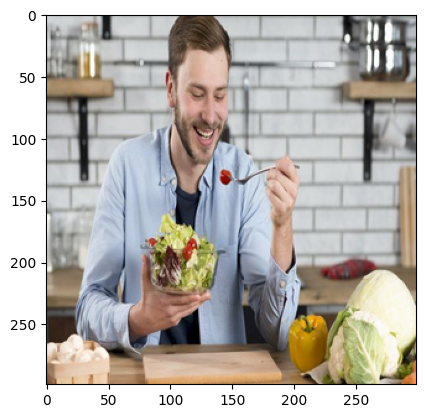

In [158]:
!wget 'https://i.pinimg.com/originals/86/af/b0/86afb044d3cef03374d78c3a988f4459.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:19:12--  https://img.freepik.com/premium-photo/photo-of-cute-cat-and-dog-domestic-animals_763111-107287.jpg
Resolving img.freepik.com (img.freepik.com)... 23.54.155.106, 23.54.155.100, 2600:1413:5000:d::1736:9ba6, ...
Connecting to img.freepik.com (img.freepik.com)|23.54.155.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59195 (58K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  57.81K  --.-KB/s    in 0s      

2025-10-28 15:19:12 (191 MB/s) - ‘data/img.jpg’ saved [59195/59195]

a woman is standing in a grassy area .
a man standing in a field with a green umbrella .
a woman standing in a field with a large umbrella .
a woman standing in a field with a green umbrella .
a woman standing in a field with a woman in the background .
a woman standing in a grassy area with a dog .
a man standing in a field with a green umbrella .
a woman standing in the middle of a road .
a woman in a black shirt and a bla

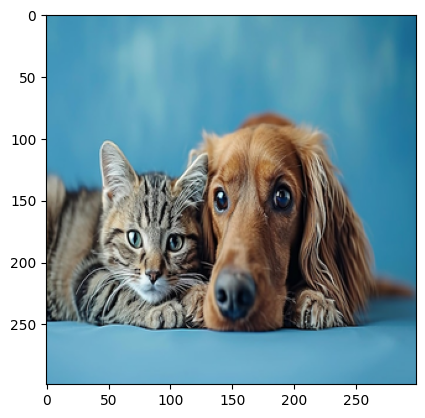

In [163]:
!wget 'https://img.freepik.com/premium-photo/photo-of-cute-cat-and-dog-domestic-animals_763111-107287.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:15:17--  https://static.mango-office.ru/project-im/medialibrary/126/1263c97d511a72fa165b4d3786ac4ccf/2.jpg
Resolving static.mango-office.ru (static.mango-office.ru)... 178.248.236.69
Connecting to static.mango-office.ru (static.mango-office.ru)|178.248.236.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212498 (208K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 207.52K   238KB/s    in 0.9s    

2025-10-28 15:15:20 (238 KB/s) - ‘data/img.jpg’ saved [212498/212498]

a man is sitting on a table with a laptop .
a woman is sitting on a table with a laptop .
a woman is sitting on a couch in a room .
a man is sitting on a table with a laptop .
a woman is holding a laptop in a room .
a man is sitting on a table with a laptop .
a man is sitting on a table with a laptop .
a woman is standing in front of a laptop computer .
a man is sitting on a table with a laptop .
a man is standing in a kitchen with a laptop

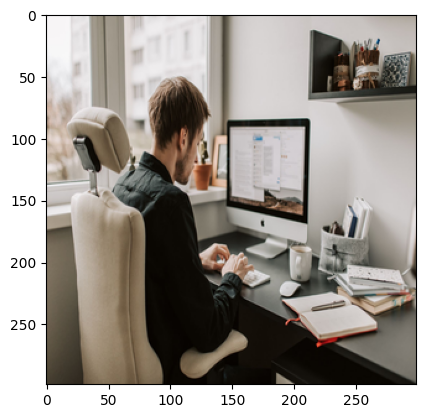

In [160]:
!wget 'https://static.mango-office.ru/project-im/medialibrary/126/1263c97d511a72fa165b4d3786ac4ccf/2.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:18:16--  https://i.pinimg.com/originals/75/d0/57/75d0578454b3978633f765757fed8276.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.0.84, 151.101.64.84, 151.101.128.84, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.0.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34465 (34K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  33.66K  --.-KB/s    in 0s      

2025-10-28 15:18:16 (196 MB/s) - ‘data/img.jpg’ saved [34465/34465]

a man is surfing on a surfboard in the ocean .
a man riding a wave on a surfboard .
a man riding a wave on a surfboard .
a man riding a wave on a surfboard in the ocean .
a man riding a wave on a surfboard in the ocean .
a man is surfing on a surfboard in the ocean .
a man riding a wave on a surfboard in the ocean .
a man is surfing on a surfboard in the ocean .
a man is surfing on a surfboard on a beach .
a man in a wetsuit riding a wave in the ocean .


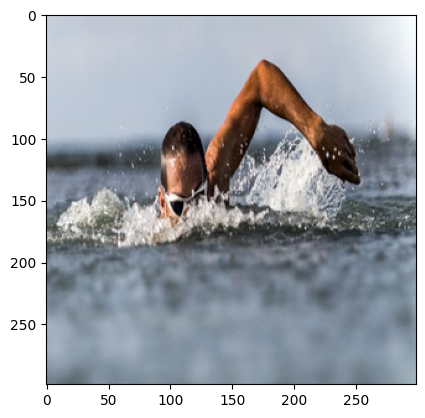

In [162]:
!wget 'https://i.pinimg.com/originals/75/d0/57/75d0578454b3978633f765757fed8276.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:21:44--  https://img.freepik.com/premium-photo/strict-looking-camera-young-male-teacher-standing-front-blackboard-write-classroom_141793-136600.jpg
Resolving img.freepik.com (img.freepik.com)... 23.200.143.8, 23.200.143.15, 2600:1413:5000:d::1736:9bae, ...
Connecting to img.freepik.com (img.freepik.com)|23.200.143.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43997 (43K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  42.97K   124KB/s    in 0.3s    

2025-10-28 15:21:47 (124 KB/s) - ‘data/img.jpg’ saved [43997/43997]

a man and a woman standing in a room with a laptop .
a man is standing in a room with a laptop and a woman in a room .
a man is standing in a living room with a laptop .
a woman is standing in a room with a laptop .
a man is playing a video game in a room .
a man is standing in a room with a laptop on a table .
a man is sitting on a couch with a laptop .
a man is sitting on a bench in fr

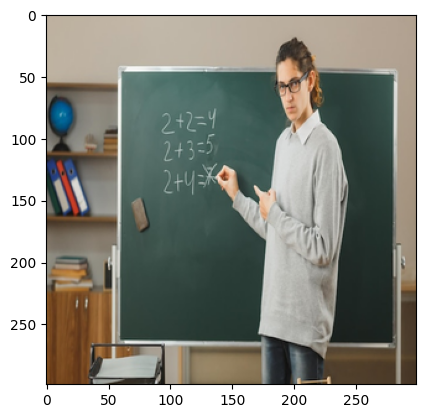

In [164]:
!wget 'https://img.freepik.com/premium-photo/strict-looking-camera-young-male-teacher-standing-front-blackboard-write-classroom_141793-136600.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-28 15:15:29--  https://i.ytimg.com/vi/bTX7EfNrWTk/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 64.233.170.119, 74.125.200.119, 74.125.130.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|64.233.170.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110103 (108K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 107.52K  --.-KB/s    in 0.001s  

2025-10-28 15:15:29 (126 MB/s) - ‘data/img.jpg’ saved [110103/110103]

a man is standing in a kitchen with a woman in a kitchen .
a man standing in a kitchen with a woman in a kitchen .
a man is standing in a kitchen with a woman in a kitchen .
a man is standing in front of a table with a pizza .
a man standing in a kitchen with a woman in a kitchen .
a man and woman standing in a kitchen with a man in a room .
a man standing in front of a table with a pizza .
a man is standing in a kitchen with a woman in front of a table .
a man and a woman standing in a kitc

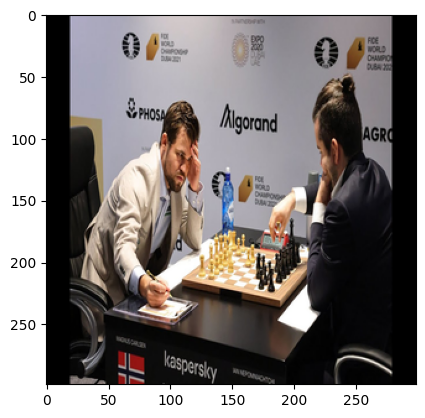

In [161]:
!wget 'https://i.ytimg.com/vi/bTX7EfNrWTk/maxresdefault.jpg' -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299), Image.Resampling.LANCZOS)
img = np.array(img).astype('float32') / 255.

plt.imshow(img)


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))